# Geometrical form factor calculation

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#%matplotlib notebook

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rc('font', size = 12)

## Functions

### Intersection area $\mathcal{A}$ calculation

In [76]:
def intersection_distance(r_0, r_1, d):
    return (r_0**2 - r_1**2 + d**2)/(2*d)

def intersection_angle(r_0, r_1, d):
    return np.arccos(intersection_distance(r_0, r_1, d)/r_0)

def chi_function(r_0, r_1, d):
    return ((r_0 + r_1)**2 - d**2)*(d**2 - (r_0 - r_1)**2)

def intersection_area(r_0, r_1, d):    
    c_1, c_2, c_3 = d > r_0 + r_1, d < np.abs(r_0 - r_1), (d <= r_0 + r_1)*(d >= np.abs(r_0 - r_1))    
    if c_1:
        return 0
    elif c_2:
        return np.pi * np.minimum(r_0**2, r_1**2) 
    elif c_3:
        chi = chi_function(r_0, r_1, d)
        varphi_0, varphi_1 = intersection_angle(r_0, r_1, d), intersection_angle(r_1, r_0, d)
        return varphi_0*r_0**2 + varphi_1*r_1**2 - 0.5*np.sqrt(chi)

### Geometrical probability factor $\xi$ calculation

In [77]:
def image(r, f, z):
    return r * f/z

def geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x, y, z):
    r_telescope_prime = image(r_telescope, f, z)
    r_mirror_prime = image(r_mirror, f, z)
    r_point_prime = image(np.sqrt(x**2 + y**2), f, z)
    r_aperture = phi_telescope * f
    a_0 = intersection_area(r_aperture, r_telescope_prime, r_point_prime)
    a_1 = intersection_area(r_aperture, r_mirror_prime, r_point_prime)
    return (a_0 - a_1)/(np.pi*(r_telescope_prime**2 - r_mirror_prime**2))

### Geometrical factor form integrand $\xi \times f$ calculation

In [78]:
def laser_beam_width(r_laser, phi_laser, density_function, z):
    if density_function == gaussian_density_function:
        return np.sqrt(r_laser**2 + (phi_laser*z)**2)
    elif density_function == uniform_density_function:
        return r_laser + phi_laser*z

def telescope_beam_width(r_telescope, phi_telescope, z):
    return r_telescope + np.tan(phi_telescope)*z

def geometrical_factor_form_integrand(density_function, r_telescope,phi_telescope, r_laser, phi_laser, r_mirror, f, d, x, y, z):
    density = density_function(r_laser, phi_laser, d, x, y, z)
    gpf = geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x, y, z)
    return density * gpf

def geometrical_factor_form_integrand_matrix(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x, y, z):
    matrix = np.zeros((x.shape[0], y.shape[0]))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            matrix[i, j] = geometrical_factor_form_integrand(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x[i], y[j], z)
    return matrix

### Probability density function $f$ calculation

In [79]:
def theta(r):
    return 0.5*(1 + r/np.abs(r))

def uniform_density_function(r_laser, phi_laser, d, x, y, z):
    r_prime = np.sqrt(x**2 + y**2 + d**2 - 2*d*x)
    return theta(laser_beam_width(r_laser, phi_laser, uniform_density_function, z) - r_prime) / (np.pi*laser_beam_width(r_laser, phi_laser, uniform_density_function, z)**2)

def gaussian_density_function(r_laser, phi_laser, d, x, y, z):
    new_r_laser = laser_beam_width(r_laser, phi_laser, gaussian_density_function, z)
    return 2 * np.exp((-2*((x - d)**2 + y**2)) / new_r_laser**2) / (np.pi*new_r_laser**2)

### Integration methods

In [80]:
def rectangular_integration(x, y, matrix):
    if x.shape[0] < 2:
        return 0
    else:
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        integral = 0
        for i in range(matrix.shape[0]-1):
            for j in range(matrix.shape[1]-1):
                integral += 0.25*dx*dy * (matrix[i, j] + matrix[i+1, j] + matrix[i, j+1] + matrix[i+1, j+1]) 
        return integral

def monte_carlo_integration(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, z, n):
    integral = 0
    if density_function == gaussian_density_function:
        for k in range(n):
            u_1, u_2 = np.random.normal(0, 1), np.random.normal(0, 1)
            x = 0.5*laser_beam_width(r_laser, phi_laser, density_function, z)*u_1 + d
            y = 0.5*laser_beam_width(r_laser, phi_laser, density_function, z)*u_2
            integral += geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x, y, z)
    elif density_function == uniform_density_function:
        for k in range(n):
            u_1, u_2 = np.random.uniform(0, 1), np.random.uniform(0, 1)
            x = 3*laser_beam_width(r_laser, phi_laser, density_function, z)*(u_1 - 0.5) + d
            y = 3*laser_beam_width(r_laser, phi_laser, density_function, z)*(u_2 - 0.5)
            while np.sqrt((x - d)**2 + y**2) > laser_beam_width(r_laser, phi_laser, density_function, z):
                u_1, u_2 = np.random.uniform(0, 1), np.random.uniform(0, 1)
                x = 2*laser_beam_width(r_laser, phi_laser, density_function, z)*(u_1 - 0.5) + d
                y = 2*laser_beam_width(r_laser, phi_laser, density_function, z)*(u_2 - 0.5)
            integral += geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x, y, z)
    return integral/n

### Space restriction for integration

In [81]:
def space_restriction(density_function, r_telescope, phi_telescope, r_laser, phi_laser, d, x, y, z, z_list):
    index = np.arange(0, x.shape[0], 1)
    r_telescope_z = telescope_beam_width(r_telescope, phi_telescope, z)
    r_laser_z = laser_beam_width(r_laser, phi_laser, density_function, z)
    if d >= r_laser_z + r_telescope_z:
        x_z = np.array([])
        y_z = np.array([])
    else:
        if density_function == uniform_density_function:
            if d <= np.abs(r_laser_z - r_telescope_z):
                x_z = x[index[(x > d - r_laser_z)*(x < d + r_laser_z)]]
                y_z = y[index[(y > -r_laser_z)*(y < r_laser_z)]]
            else:
                if r_laser_z > d:
                    y_z = y[index[(y > -r_telescope_z)*(y < r_telescope_z)]]
                else:
                    alpha = np.arccos(np.sqrt(1 - r_laser_z**2/d**2))
                    y_z = y[index[(y > -r_telescope_z*np.sin(alpha))*(y < r_telescope_z*np.sin(alpha))]]
                x_z = x[index[(x > d - r_laser_z)*(x < r_telescope_z)]]
        else:
            x_z = x[index[(x > -r_telescope_z)*(x < r_telescope_z)]]
            y_z = y[index[(y > -r_telescope_z)*(y < r_telescope_z)]]
    return x_z, y_z

### Circle display

In [82]:
def circle_display(r, x_0, y_0, circle_name, color):
    t = np.linspace(0, 2*np.pi, 100)
    x = r*np.cos(t) + x_0
    y = r*np.sin(t) + y_0
    plt.plot(x_0, y_0, 'o', color = color, label = circle_name)
    plt.plot(x, y, color)
    plt.axis('equal')

## Tests

### Datas initialization

In [83]:
r_telescope, phi_telescope = 0.175, 7.5e-4
r_laser, phi_laser = 0.01, 5e-3
d = 0.2
r_mirror = 0.04
f = 1

### Geometrical probability factor display with $(x, y)$ fixed

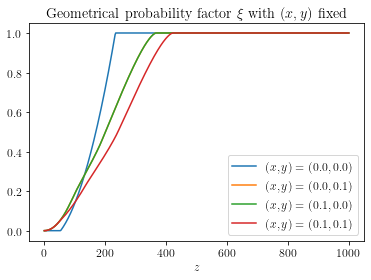

In [84]:
n = 500
z_min, z_max = 1e-3, 1000
z_list = np.linspace(z_min, z_max, n)

x_list = np.linspace(0, 0.1, 2)
y_list = np.linspace(0, 0.1, 2)

plt.figure()
for x in x_list:
    for y in y_list:
        gpf = np.array([geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x, y, z) for z in z_list])
        plt.plot(z_list, gpf, label = "$(x, y) = (" + str(x) + "," + str(y) + ")$")
plt.title("Geometrical probability factor $\\xi$ with $(x, y)$ fixed")
plt.xlabel("$z$")
plt.legend()
plt.show()

### Geometrical factor form integrand with gaussian density function and $z$ fixed

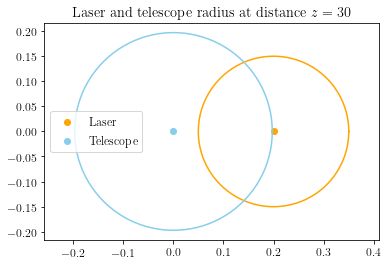

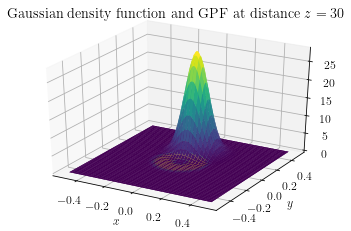

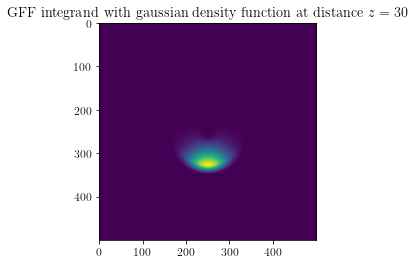

In [85]:
delta = 1
minimum_x, minimum_y = -0.5, -0.5

x = np.linspace(minimum_x, delta + minimum_x, n)
y = np.linspace(minimum_y, delta + minimum_y, n)
z = 30

density_function = gaussian_density_function

new_r_laser = laser_beam_width(r_laser, phi_laser, density_function, z)
new_r_telescope = telescope_beam_width(r_telescope, phi_telescope, z)

plt.figure()
circle_display(new_r_laser, d, 0, "Laser", 'orange')
circle_display(new_r_telescope, 0, 0, "Telescope", 'skyblue')
plt.title("Laser and telescope radius at distance $z = " + str(z) + "$")
plt.legend()
plt.show()

gpf_matrix = np.zeros((n, n))
density_matrix = np.zeros((n, n))
gff_integrand = geometrical_factor_form_integrand_matrix(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x, y, z)

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        gpf_matrix[i, j] = geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x[i], y[j], z)
        density_matrix[i, j] = density_function(r_laser, phi_laser, d, x[i], y[j], z)

X, Y = np.meshgrid(x, y)

figure = plt.figure()
axes = figure.gca(projection = '3d')
axes.plot_surface(X, Y, gpf_matrix, cmap = cm.viridis)
axes.plot_surface(X, Y, density_matrix, cmap = cm.viridis)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Gaussian density function and GPF at distance $z = " + str(z) + "$")
plt.show()

plt.figure()
plt.imshow(gff_integrand)
plt.title("GFF integrand with gaussian density function at distance $z = " + str(z) + "$")
plt.show()

### Geometrical factor form integrand with uniform density function

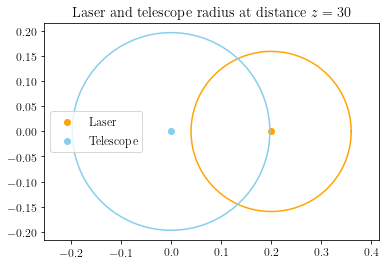

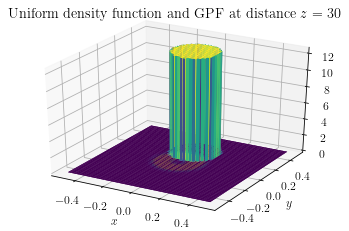

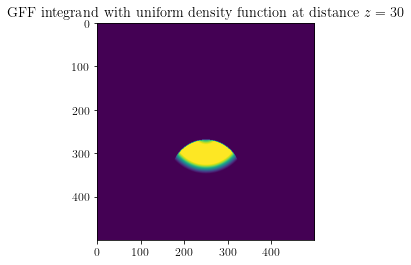

In [86]:
delta = 1
n = 500
minimum_x, minimum_y = -0.5, -0.5

x = np.linspace(minimum_x, delta + minimum_x, n)
y = np.linspace(minimum_y, delta + minimum_y, n)
z = 30

density_function = uniform_density_function

new_r_laser = laser_beam_width(r_laser, phi_laser, density_function, z)
new_r_telescope = telescope_beam_width(r_telescope, phi_telescope, z)

plt.figure()
circle_display(new_r_laser, d, 0, "Laser", 'orange')
circle_display(new_r_telescope, 0, 0, "Telescope", 'skyblue')
plt.title("Laser and telescope radius at distance $z = " + str(z) + "$")
plt.legend()
plt.show()

gpf_matrix = np.zeros((n, n))
density_matrix = np.zeros((n, n))
gff_integrand = geometrical_factor_form_integrand_matrix(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x, y, z)

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        gpf_matrix[i, j] = geometrical_probability_factor(r_telescope, phi_telescope, r_mirror, f, x[i], y[j], z)
        density_matrix[i, j] = density_function(r_laser, phi_laser, d, x[i], y[j], z)

X, Y = np.meshgrid(x, y)

figure = plt.figure()
axes = figure.gca(projection = '3d')
axes.plot_surface(X, Y, gpf_matrix, cmap = cm.viridis)
axes.plot_surface(X, Y, density_matrix, cmap = cm.viridis)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Uniform density function and GPF at distance $z = " + str(z) + "$")
plt.show()

plt.figure()
plt.imshow(gff_integrand)
plt.title("GFF integrand with uniform density function at distance $z = " + str(z) + "$")
plt.show()

### Integration methods

#### Datas initialization

In [87]:
r_telescope, phi_telescope = 0.1, 0.6e-3
r_laser, phi_laser = 0.005, 0.5e-3
d = 0.22
r_mirror = 0.038
f = 1

#### Rectangular integration

In [88]:
z_list = np.linspace(1, 4000, 20)

rectangular_integral_list = np.zeros(z_list.shape[0])

r_telescope_max = telescope_beam_width(r_telescope, phi_telescope, z_list[-1])
x = np.linspace(-r_telescope_max, r_telescope_max, n)
y = np.linspace(-r_telescope_max, r_telescope_max, n)
index = np.arange(0, n, 1)

density_function = gaussian_density_function

for k in range(z_list.shape[0]):
    x_z, y_z = space_restriction(density_function, r_telescope, phi_telescope, r_laser, phi_laser, d, x, y, z_list[k], z_list)
    gff_integrand = geometrical_factor_form_integrand_matrix(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x_z, y_z, z_list[k])
    rectangular_integral_list[k] = rectangular_integration(x_z, y_z, gff_integrand)    

#### Monte-Carlo integration

In [89]:
monte_carlo_integral_list = np.zeros(z_list.shape[0])
iteration_nb = 1000

for k in range(z_list.shape[0]):
    monte_carlo_integral_list[k] = monte_carlo_integration(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, z_list[k], iteration_nb)

#### Results display

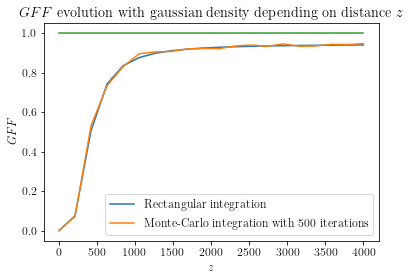

In [90]:
plt.figure()
plt.plot(z_list, rectangular_integral_list, label = "Rectangular integration")
plt.plot(z_list, monte_carlo_integral_list, label = "Monte-Carlo integration with " + str(n) + " iterations")
plt.plot(z_list, np.ones(z_list.shape[0]))
plt.xlabel("$z$")
plt.ylabel("$GFF$")
plt.title("$GFF$ evolution with gaussian density depending on distance $z$")
plt.legend()
plt.show()

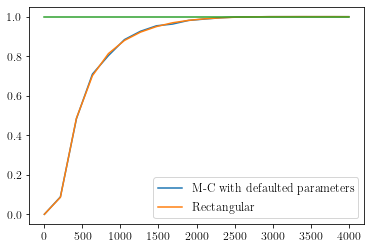

In [91]:
z_list = np.linspace(1, 4000, 20)
iteration_nb = 1000

density_function = uniform_density_function

gff_1, gff_2 = np.zeros(z_list.shape[0]), np.zeros(z_list.shape[0])

for k in range(z_list.shape[0]):
    gff_1[k] = monte_carlo_integration(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, z_list[k], iteration_nb)
    x_z, y_z = space_restriction(density_function, r_telescope, phi_telescope, r_laser, phi_laser, d, x, y, z_list[k], z_list)
    gff_integrand = geometrical_factor_form_integrand_matrix(density_function, r_telescope, phi_telescope, r_laser, phi_laser, r_mirror, f, d, x, y, z_list[k])
    gff_2[k] = rectangular_integration(x, y, gff_integrand)
    
plt.figure()
plt.plot(z_list, gff_1, label = "M-C with defaulted parameters")
plt.plot(z_list, gff_2, label = "Rectangular")
plt.plot(z_list, np.ones(z_list.shape[0]))
plt.legend()
plt.show()

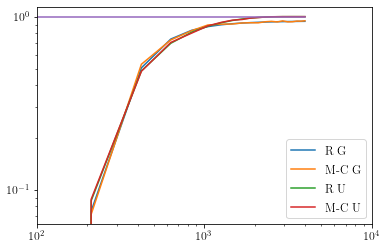

In [94]:
plt.figure()
plt.loglog(z_list, rectangular_integral_list, label = "R G")
plt.loglog(z_list, monte_carlo_integral_list, label = "M-C G")
plt.loglog(z_list, gff_2, label = "R U")
plt.loglog(z_list, gff_1, label = "M-C U")
plt.loglog(z_list, np.ones(z_list.shape[0]))
plt.legend()
plt.xlim(10**2, 10**4)
plt.show()